In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
words = set(nltk.corpus.words.words())
from stop import stop_words
from textblob import TextBlob
import requests
from pycomp.viz.insights import *
from collections import Counter
import gensim
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from zeugma.embeddings import EmbeddingTransformer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()



import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [2]:
text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt').text
label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt').text
val_text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt').text
val_label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt').text
text_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt').text
label_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt').text

# Text PreProcessing

In [3]:
def process(label,text):
    
    tag = []
    for sent in label.split("\n"):
        try:
            tag.append(int(sent))
        except ValueError:
            pass

    tweet = []
    for text in text.split('\n'):
        try:
            tweet.append(text)
        except ValueError:
            pass
        
    data = {'tweet':tweet[:-1],'tag':tag}
    df = pd.DataFrame(data)
    df['sentiment'] = df.tag.apply(lambda x:'Positive' if x==2 else 'Negative' if x==0 else 'Neutral')
    return df

In [4]:
df = process(label,text)
df_val = process(val_label,val_text)
df_test = process(label_test,text_test)

In [5]:
df

,tweet,tag,sentiment
0,"""QT @user In the original draft of the 7th boo...",2,Positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,Neutral
2,Sorry bout the stream last night I crashed out...,1,Neutral
3,Chase Headley's RBI double in the 8th inning o...,1,Neutral
4,@user Alciato: Bee will invest 150 million in ...,2,Positive
...,...,...,...
45610,"@user \""""So amazing to have the beautiful Lady...",2,Positive
45611,"9 September has arrived, which means Apple's n...",2,Positive
45612,Leeds 1-1 Sheff Wed. Giuseppe Bellusci securin...,2,Positive
45613,@user no I'm in hilton head till the 8th lol g...,1,Neutral


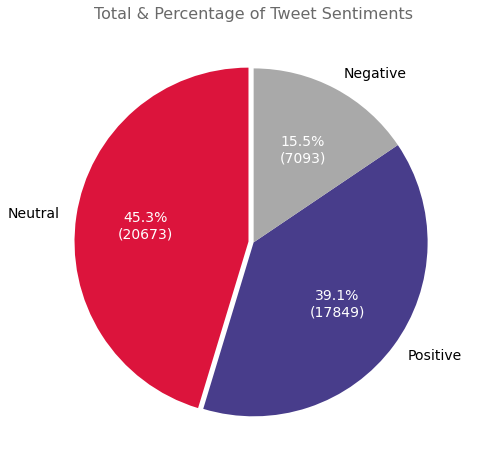

In [6]:
plot_pie_chart(df=df, col='sentiment', colors=['crimson', 'darkslateblue', 'darkgrey'],
               explode=(0.03, 0, 0),
               title="Total & Percentage of Tweet Sentiments")

## Text Cleaning

In [7]:

def cleaner(tweet):
    
    tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
#     tweet = ([word for word in tweet if not word in stop_words])
#     tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet])
    tweet = " ".join([stemmer.stem(word) for word in tweet])
    
    tweet = tweet.replace("user", "")


    return  tweet

In [8]:
def cleanup(df):
    
    train_cleaned = df['tweet'].apply(cleaner)
    df['tweet'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return df   

In [9]:
train_cleaned = cleanup(df)
val_cleaned = cleanup(df_val)
test_cleaned = cleanup(df_test)

In [10]:
train_cleaned

,tweet,tag,sentiment
0,qt in the origin draft of the 7th book remu lu...,2,Positive
1,ben smith smith concuss remain out of the line...,1,Neutral
2,sorri bout the stream last night crash out but...,1,Neutral
3,chase headley rbi doubl in the 8th inning off ...,1,Neutral
4,alciato bee will invest 150 million in januari...,2,Positive
...,...,...,...
45610,so amaz to have the beauti ladi gaga at the sh...,2,Positive
45611,septemb ha arriv which mean appl new iphon is ...,2,Positive
45612,leed 11 sheff wed giusepp bellusci secur lufc ...,2,Positive
45613,no im in hilton head till the 8th lol go to ja...,1,Neutral


# Exploratory Data Analysis (EDA)

In [11]:
from PIL import Image
mask = np.array(Image.open("/Users/karampruthi/Downloads/twitter.png"))
def word_cloud(sentiment):
    
    negative_words = ' '.join([text for text in train_cleaned['tweet'][train_cleaned['sentiment']==sentiment]])
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(random_state=21, max_font_size=110,contour_color='red',
                          font_path = '/Users/karampruthi/Downloads/reglisse/Reglisse_Fill.otf',
                          background_color='white',mask=mask,
                          stopwords=stop_words).generate(negative_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
    plt.title(sentiment+' Words', fontsize=35,color = 'darkslateblue',family='serif',weight = 'heavy')

,Common_words,count
0,the,5787
1,to,3243
2,in,2009
3,and,1948
4,is,1885
5,of,1847
6,on,1775
7,it,1664
8,may,1552
9,be,1466


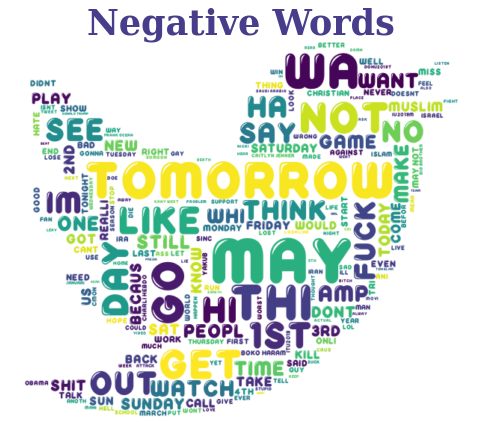

In [12]:
word_cloud('Negative')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==0].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

,Common_words,count
0,the,17820
1,to,9196
2,in,6551
3,on,6294
4,and,5380
5,of,4920
6,for,4386
7,is,3828
8,it,3624
9,at,3589


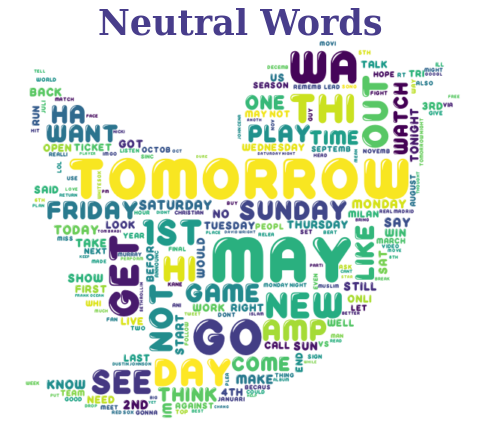

In [13]:
word_cloud('Neutral')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==1].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

,Common_words,count
0,the,14314
1,to,8463
2,and,5276
3,in,5089
4,on,5006
5,for,4233
6,of,4104
7,is,3962
8,it,3894
9,you,3670


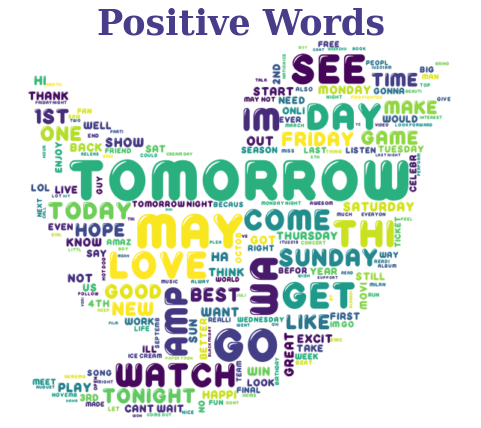

In [14]:
word_cloud('Positive')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==2].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

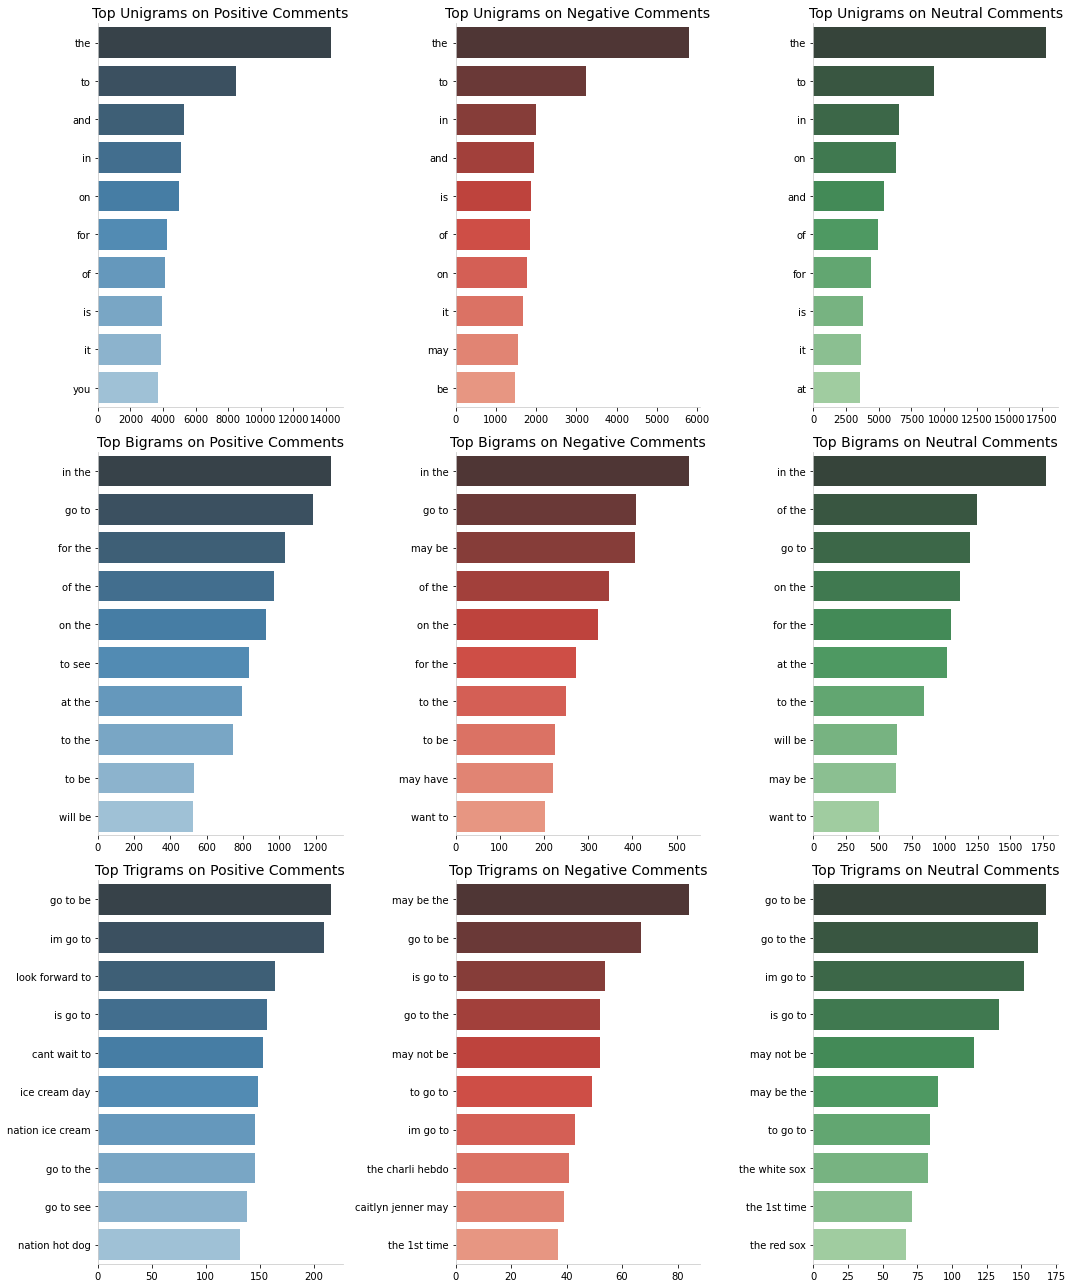

In [15]:
def ngrams_count(corpus, ngram_range, n=-1):
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer( ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

# Splitting the corpus into positive and negative comments
positive_comments = train_cleaned['tweet'][train_cleaned['sentiment']=='Positive']
negative_comments = train_cleaned['tweet'][train_cleaned['sentiment']=='Negative']
neutral_comments = train_cleaned['tweet'][train_cleaned['sentiment']=='Neutral']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)
unigrams_neu = ngrams_count(neutral_comments, (1, 1), 10)


# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)
bigrams_neu = ngrams_count(neutral_comments, (2, 2), 10)



# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)
trigrams_neu = ngrams_count(neutral_comments, (3, 3), 10)



# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Unigrams on Neutral Comments': unigrams_neu,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Bigrams on Neutral Comments': bigrams_neu,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
    'Top Trigrams on Neutral Comments': trigrams_neu,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 18))
i, j, k = 0, 0, 0
colors = ['Blues_d', 'Reds_d','Greens_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.tight_layout()
plt.show()

# OverSampling to handle imbalance train dataset

In [16]:
train_cleaned['tweet'].shape

(45615,)

In [17]:
from imblearn.over_sampling import RandomOverSampler

inputs = train_cleaned['tweet'].values.reshape(-1,1)
target = train_cleaned['tag']
smote = RandomOverSampler()
inputs, target = smote.fit_sample(inputs,target)

inputs = inputs.reshape(inputs.shape[0],)

In [18]:
inputs.shape

(62019,)

# Feature Extraction

## Bag of Words

In [19]:
def Bag_words(vect, x_train, y_train, validation, test, ngram):
    
    c = vect(ngram_range=(1,ngram))

    x_train = c.fit_transform(inputs)
    shape = x_train.shape 
    if ngram==1:
        print('Train size with Unigram:',shape)
    elif ngram ==2:
        print('Train size with Bigram:',shape)
    elif ngram ==3:
        print('Train size with Trigram:',shape)
        
    val_train = c.transform(validation['tweet'].values)
    test_train = c.transform(test['tweet'].values)
    LR= LogisticRegression(max_iter=500)  
    LR.fit(x_train,target)
    val_pred = LR.predict(val_train)
    print('Recall Score on Validation Data -->',recall_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(test_train)
    print('Recall Score on Test Data       -->',recall_score(test['tag'],test_pred,average='macro'),'\n')

##  CountVectorizer

In [20]:
for i in range(1,4):
    Bag_words(CountVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (62019, 42414)
Recall Score on Validation Data --> 0.6533249919325869
Recall Score on Test Data       --> 0.5771130956597604 

Train size with Bigram: (62019, 368705)
Recall Score on Validation Data --> 0.6420970028564965
Recall Score on Test Data       --> 0.5917909126373199 

Train size with Trigram: (62019, 943020)
Recall Score on Validation Data --> 0.6404472227257038
Recall Score on Test Data       --> 0.5873091055667556 



## TF-IDF

In [21]:
for i in range(1,4):
    Bag_words(TfidfVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (62019, 42414)
Recall Score on Validation Data --> 0.6643010646175204
Recall Score on Test Data       --> 0.6012757048780752 

Train size with Bigram: (62019, 368705)
Recall Score on Validation Data --> 0.6713048437731982
Recall Score on Test Data       --> 0.6134884494467397 

Train size with Trigram: (62019, 943020)
Recall Score on Validation Data --> 0.6601833468922077
Recall Score on Test Data       --> 0.6181672752323631 



## Word2Vec

In [22]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.vocab]
    if len(doc)==0:
        doc = ['qt']
    return np.mean(w2v[doc], axis=0)

def Word_Vec(x_train,y_train, validation, test):
    
    x_train = pd.DataFrame(x_train)
    words_train = x_train[0].apply(word_tokenize)
    words_validation = validation['tweet'].apply(word_tokenize)
    words_test = test['tweet'].apply(word_tokenize)
    
    global w2v
    w2v = gensim.models.Word2Vec(words_train, size=350, window=10, min_count=1, iter=20)
    words_train = pd.DataFrame(words_train)
    words_validation = pd.DataFrame(words_validation)
    words_test = pd.DataFrame(words_test)

    x_train = list(words_train[0].apply(document_vector))
    x_val = list(words_validation['tweet'].apply(document_vector))
    x_test = list(words_test['tweet'].apply(document_vector))
    
    LR = LogisticRegression(C=500,multi_class='multinomial')
    LR.fit(x_train,y_train)
    
    val_pred = LR.predict(x_val)
    print('Recall Score on Validation Data -->',recall_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(x_test)
    print('Recall Score on Test Data       -->',recall_score(test['tag'],test_pred,average='macro'))

In [23]:
print('*******WORD2VEC********')
Word_Vec(inputs, target, val_cleaned,test_cleaned)

*******WORD2VEC********
Recall Score on Validation Data --> 0.5788655788655789
Recall Score on Test Data       --> 0.5531443754232251


## Matrix Factorization with Glove

In [24]:
glove = EmbeddingTransformer('glove')
def Glove(x_train, y_train, validation, test):
    
    x_train = glove.transform(x_train)
    x_val = glove.transform(validation['tweet'])
    x_test = glove.transform(test['tweet'])
    
    LR = LogisticRegression(max_iter=500) 
    LR.fit(x_train,y_train)
    val_pred = LR.predict(x_val)
    print('Recall Score on Validation Data -->',recall_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(x_test)
    print('Recall Score on Test Data       -->',recall_score(test['tag'],test_pred,average='macro'))

In [25]:
print('******GLOVE******')
Glove(inputs,target,val_cleaned,test_cleaned)

******GLOVE******
Recall Score on Validation Data --> 0.546436334411018
Recall Score on Test Data       --> 0.5449438650716893
